In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('data_for_vis.csv')
df.head()

,year,month,day,lat,lon,vgs,ugs,adts
0,1993.0,1.0,1.0,34.125,127.625,-0.0256,-0.0160,0.5677
1,1993.0,1.0,1.0,34.125,127.875,0.0241,-0.0004,0.5649
2,1993.0,1.0,1.0,34.125,128.125,0.0721,0.0364,0.5734
3,1993.0,1.0,1.0,34.125,128.375,0.1105,0.0873,0.5841
4,1993.0,1.0,1.0,34.125,128.625,0.1525,0.1366,0.6017


In [3]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.drop(columns=['year', 'month', 'day'])

In [4]:
df['velocity_magnitude'] = np.sqrt(df['vgs']**2 + df['ugs']**2)
df.head()

,lat,lon,vgs,ugs,adts,date,velocity_magnitude
0,34.125,127.625,-0.0256,-0.0160,0.5677,1993-01-01,0.030189
1,34.125,127.875,0.0241,-0.0004,0.5649,1993-01-01,0.024103
2,34.125,128.125,0.0721,0.0364,0.5734,1993-01-01,0.080767
3,34.125,128.375,0.1105,0.0873,0.5841,1993-01-01,0.140825
4,34.125,128.625,0.1525,0.1366,0.6017,1993-01-01,0.204734


In [ ]:
from sklearn.metrics import mean_absolute_error

window_sizes = [3, 7, 14, 30]
for window in window_sizes:
    new[f'rolling_{window}'] = new.groupby(['lat', 'lon'])['velocity_magnitude'].transform(lambda x: x.rolling(window, min_periods=1).mean())

# Compare MAE
for window in window_sizes:
    mae = mean_absolute_error(new['velocity_magnitude'], new[f'rolling_{window}'])
    print(f'Window {window}: MAE = {mae:.4f}')


**Tsunamis and cyclones cause rapid shifts in ocean currents, velocity, and wave heights.**

**A small rolling window (e.g., 3-day window) helps capture these changes quickly.**


In [5]:
df['velocity_rolling_mean'] = df.groupby(['lat', 'lon'])['velocity_magnitude'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['velocity_rolling_std'] = df.groupby(['lat', 'lon'])['velocity_magnitude'].transform(lambda x: x.rolling(window=5, min_periods=1).std())


In [6]:
df.head()

,lat,lon,vgs,ugs,adts,date,velocity_magnitude,velocity_rolling_mean,velocity_rolling_std
0,34.125,127.625,-0.0256,-0.0160,0.5677,1993-01-01,0.030189,0.030189,NaN
1,34.125,127.875,0.0241,-0.0004,0.5649,1993-01-01,0.024103,0.024103,NaN
2,34.125,128.125,0.0721,0.0364,0.5734,1993-01-01,0.080767,0.080767,NaN
3,34.125,128.375,0.1105,0.0873,0.5841,1993-01-01,0.140825,0.140825,NaN
4,34.125,128.625,0.1525,0.1366,0.6017,1993-01-01,0.204734,0.204734,NaN


In [7]:
df.isna().sum()

lat                         0
lon                         0
vgs                         0
ugs                         0
adts                        0
date                        0
velocity_magnitude          0
velocity_rolling_mean       0
velocity_rolling_std     1824
dtype: int64

In [8]:
df = df.dropna(subset=['velocity_rolling_std'])
df.isna().sum()

lat                      0
lon                      0
vgs                      0
ugs                      0
adts                     0
date                     0
velocity_magnitude       0
velocity_rolling_mean    0
velocity_rolling_std     0
dtype: int64

In [9]:
df.shape

(17313650, 9)

In [10]:
unique_locations = df[['lat', 'lon']].drop_duplicates()

# Get the count of unique locations
num_unique_locations = unique_locations.shape[0]
print(f"Number of unique locations: {num_unique_locations}")

Number of unique locations: 1824


In [11]:
import folium

# Create a map centered around the average latitude and longitude
map_center = [df['lat'].mean(), df['lon'].mean()]
mymap = folium.Map(location=map_center, zoom_start=2)

# Add markers for each unique location
for _, row in unique_locations.iterrows():
    folium.Marker([row['lat'], row['lon']]).add_to(mymap)

# Display the map (if running in a Jupyter notebook)
mymap

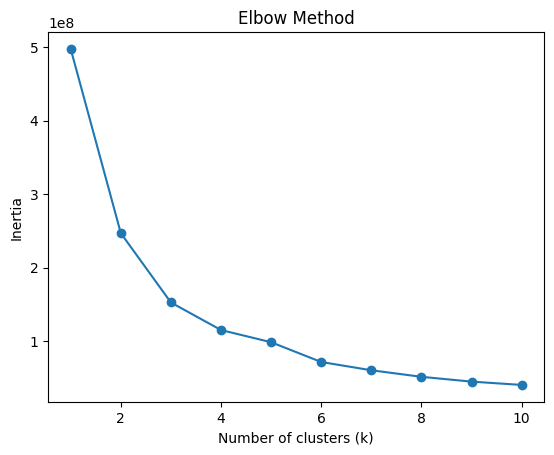

In [12]:
from sklearn.cluster import KMeans

inertia_values = []

for k in range(1,11):
    kmeans = KMeans(n_clusters = k , random_state = 42)
    kmeans.fit(df[['lat','lon']])
    inertia_values.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia_values, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

**inertia is decreasig slow after 5 clusters so we will continue with 5 clusters**

In [13]:
kmeans = KMeans(n_clusters = 5, random_state = 42)
df['region'] = kmeans.fit_predict(df[['lat','lon']])

In [14]:
df.head()

,lat,lon,vgs,ugs,adts,date,velocity_magnitude,velocity_rolling_mean,velocity_rolling_std,region
1824,34.125,127.625,-0.0575,-0.0047,0.5545,1993-01-02,0.057692,0.043940,0.019448,4
1825,34.125,127.875,0.0119,0.0112,0.5476,1993-01-02,0.016342,0.020222,0.005488,4
1826,34.125,128.125,0.0768,0.0468,0.5555,1993-01-02,0.089936,0.085352,0.006483,4
1827,34.125,128.375,0.1371,0.0989,0.5689,1993-01-02,0.169049,0.154937,0.019958,4
1828,34.125,128.625,0.1917,0.1535,0.5934,1993-01-02,0.245583,0.225158,0.028885,4


In [18]:
df['z_velocity_region'] = df.groupby('region')['velocity_magnitude'].transform(lambda x: (x - x.mean()) / x.std())
df['z_adts_region'] = df.groupby('region')['adts'].transform(lambda x: (x - x.mean()) / x.std())

df['tsunami_alert'] = ((df['z_velocity_region'] > 3.5) & (df['z_adts_region'] > 3.5)).astype(int)
df['tsunami_alert'].value_counts()

tsunami_alert
0    17301781
1       11869
Name: count, dtype: int64

In [ ]:
import folium
m = folium.Map(location=[df['lat'].mean(), df['lon'].mean()], zoom_start=7) # Center the map

# Create heatmap data (list of (lat, lon, intensity) tuples)
heatmap_data = [[row['lat'], row['lon'], row['velocity_magnitude']] for index, row in df.iterrows()]

HeatMap(heatmap_data, radius=8, blur=5).add_to(m)
m

In [24]:
from sklearn.model_selection import train_test_split

X = df.drop(['lat','lon','vgs','ugs','date','z_velocity_region','z_adts_region','tsunami_alert'],axis = 1)
y = df['tsunami_alert']


In [28]:
X_train , X_test , y_train , y_test = train_test_split(X,y, test_size = 0.30 , random_state = 42, stratify= y)

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [34]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, roc_auc_score, make_scorer

initial_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

param_grid = {
    'scale_pos_weight': [0.1 * initial_weight, 0.5 * initial_weight, initial_weight, 2 * initial_weight, 5 * initial_weight, 10 * initial_weight]  # Example range
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='binary')

grid_search = GridSearchCV(
    XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

best_weight = grid_search.best_params_['scale_pos_weight']
print("Best scale_pos_weight:", best_weight)

model = XGBClassifier(scale_pos_weight=best_weight, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


MemoryError: Unable to allocate 9.25 MiB for an array with shape (9695644,) and data type bool